In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex
from matplotlib import ticker
import seaborn as sns
import shap
import joblib
from glob import glob
from sklearn.inspection import partial_dependence

import sys
sys.path.append("../scripts")
from experiments import load_split, PROTECTED_ATTRIBUTES

from credit_pipeline import training, evaluate
from credit_pipeline.training import EBE # small fix to be able to load models

%load_ext autoreload
%autoreload 2


2024-06-20 08:58:16.543022: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 08:58:16.579932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 08:58:16.579965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 08:58:16.581145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 08:58:16.587336: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 08:58:16.588133: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
os.makedirs("explainability_data", exist_ok = True)

In [37]:
def parallel_coordinates(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(1, len(columns)-1, sharey=False, figsize=(15,5))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]

    if columns_tick_format is None:
        columns_tick_format = [None for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    x = list(range(len(columns)))
    axx = axes[-1].twinx()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
        for idx in norm_df.index:
            axx.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_xlim([x[i], x[i+1]])
        ax.set_ylim([-0.05, 1.05])
        # get yticks from ax
        yticks = ax.get_yticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        if format_ is None:
            ax.set_yticklabels([np.round(yi * col_range  + col_min, 1)  for yi in yticks], fontsize = 18)
        else:
            ax.set_yticklabels([format_(yi * col_range  + col_min)  for yi in yticks], fontsize = 18)
        #ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    axes[0].set_ylim([-0.05, 1.05])

    for i, ax in enumerate(axes[:-1]):
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.set_xticklabels([columns_names[i]], fontsize = 18, rotation=45)

    axes[-1].xaxis.set_major_locator(ticker.FixedLocator([i+1, i+2]))
    axes[-1].set_xticklabels([columns_names[i+1], columns_names[i+2]], fontsize = 18, rotation = 45)

    # tick for right side of last axis
    yticks = axes[-1].get_yticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_yticklabels([np.round((yi * col_range +  col_min), 1)  for yi in yticks], fontsize = 18)
    else:
        axx.set_yticklabels([format_(yi * col_range +  col_min)  for yi in yticks], fontsize = 18)
    axx.set_axisbelow(True)
    axx.set_ylim([-0.05, 1.05])
    axx.spines['top'].set_visible(False)
    axx.spines['bottom'].set_visible(False)

    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    if color_column is not None:
        handles = [
            mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
        ]
        plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

In [8]:
dataset_name = "homecredit"
seed = 0

plot of logistic regression feature importance, gbm feature importance, and shap feature importance of both models

In [46]:
path = "../results/credit_models"
lr_features_importance = []
lgbm_features_importance = []
shap_lr_features_importance = []
shap_lgbm_features_importance = []

background_samples = 1000
n_samples = 1000

for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    X_train_preprocess = model[:-1].transform(X_train)
    features = X_train_preprocess.columns.tolist()


    categoric_features = model[1].transformers_[1][1].get_feature_names_out()
    categoric_features_mapping = model[1].transformers_[1][1].categories_
    categoric_features_mapping = {f: c for f, c in zip(categoric_features, categoric_features_mapping)}
    
    lr_features_importance.append(model[-1].coef_[0])

    explainer =shap.LinearExplainer(
       model[-1],
        X_train_preprocess.sample(background_samples),
        feature_perturbation="interventional",
    )
    shap_values = explainer(X_train_preprocess.sample(n_samples))
    shap_lr_features_importance.append(shap_values.values.mean(0))

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    lgbm_features_importance.append(model[-1].feature_importances_ / sum(model[-1].feature_importances_))

    explainer = shap.TreeExplainer(
        model[-1],
        X_train_preprocess.sample(background_samples),
        model_output="probability",
        feature_perturbation="interventional",
        
    )
    shap_values = explainer(X_train_preprocess.sample(n_samples))
    shap_lgbm_features_importance.append(shap_values.values.mean(0))
   

lr_features_importance = np.array(lr_features_importance)
lgbm_features_importance = np.array(lgbm_features_importance)
shap_lr_features_importance = np.array(shap_lr_features_importance)
shap_lgbm_features_importance = np.array(shap_lgbm_features_importance)

 99%|===================| 994/1000 [00:14<00:00]        

In [47]:
lr_features_importance = pd.DataFrame(
    data = lr_features_importance,
    columns=features
)
lgbm_features_importance = pd.DataFrame(
    data = lgbm_features_importance,
    columns=features
)
shap_lr_features_importance = pd.DataFrame(
    data = shap_lr_features_importance,
    columns=features
)
shap_lgbm_features_importance = pd.DataFrame(
    data = shap_lgbm_features_importance,
    columns=features
)

In [53]:
categoric_features_mapping

{'NAME_CONTRACT_TYPE': array(['Cash loans', 'Revolving loans'], dtype=object),
 'CODE_GENDER': array(['F', 'M', 'XNA'], dtype=object),
 'FLAG_OWN_CAR': array(['N', 'Y'], dtype=object),
 'FLAG_OWN_REALTY': array(['N', 'Y'], dtype=object),
 'HOUSETYPE_MODE': array(['block of flats', 'specific housing', 'terraced house'],
       dtype=object),
 'EMERGENCYSTATE_MODE': array(['No', 'Yes'], dtype=object)}

In [48]:
lr_features_importance.to_csv("explainability_data/lr_features_importance.csv", index = False)
lgbm_features_importance.to_csv("explainability_data/lgbm_features_importance.csv", index = False)
shap_lr_features_importance.to_csv("explainability_data/shap_lr_features_importance.csv", index = False)
shap_lgbm_features_importance.to_csv("explainability_data/shap_lgbm_features_importance.csv", index = False)

In [11]:
def filter_importance_features(df_importance):
    """Get the median (abs) importance of each feature and select the 10 featuers with highest median importance."""
    importance_values = df_importance.values
    median_importance = np.median(np.abs(importance_values), axis=0)
    sorted_idx = np.argsort(median_importance)[::-1][:10]
    features = df_importance.columns.tolist()
    features_sorted = np.array(features)[sorted_idx]
    return features_sorted

In [30]:
def plot_pc_importances(df_importance, title = ""):
    features = filter_importance_features(df_importance).tolist()
    n_f = len(features)
    imp_range = [
        df_importance[features].values.min(), df_importance[features].values.max()
    ]
    parallel_coordinates(
        df_importance,
        features,
        columns_ranges = [imp_range for _ in range(n_f)],
        columns_tick_format = None,
        columns_names = features,
        color_column = None,
        color_mapper = None,
        name_mapper = dict([(i, str(i)) for i in range(n_f)]),
        legend_order = None,
        title = title
    )

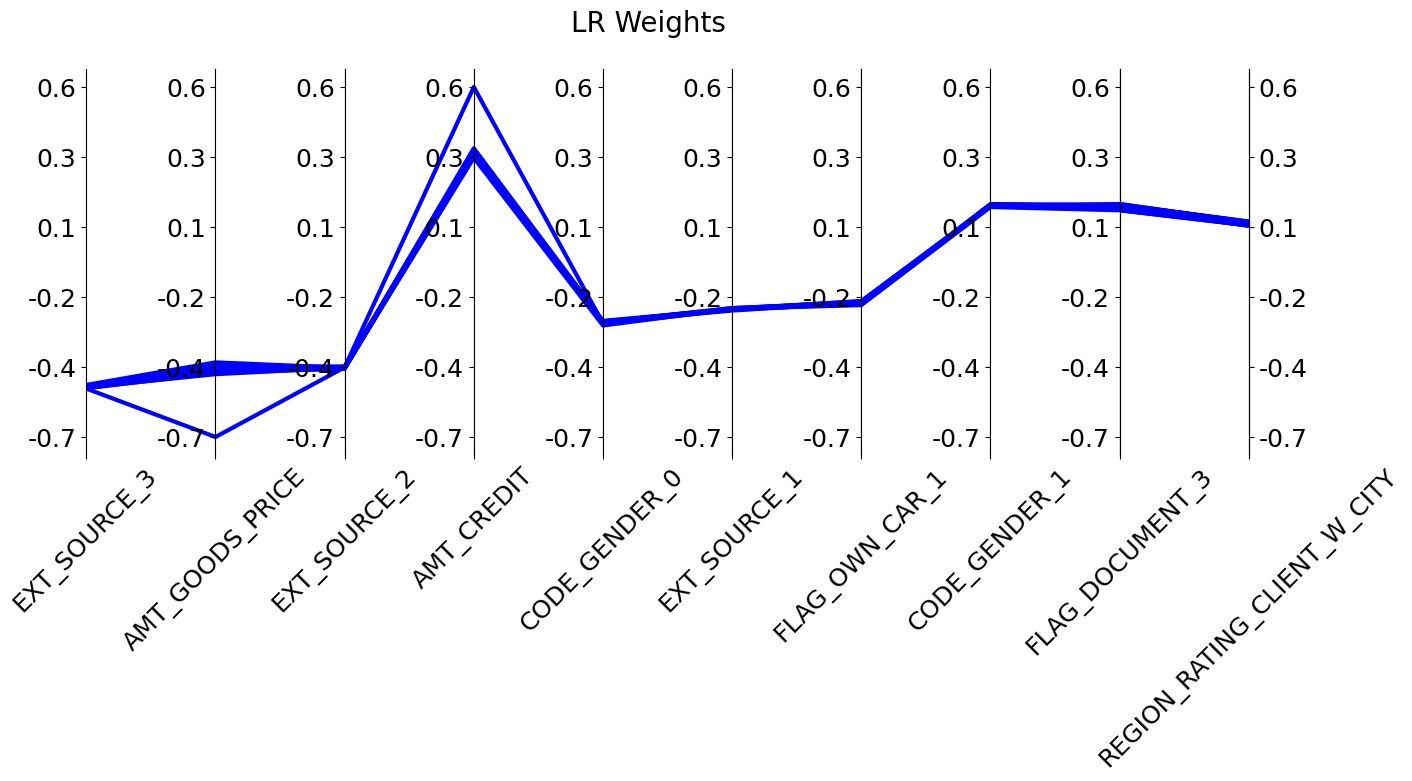

In [49]:
plot_pc_importances(lr_features_importance, "LR Weights")

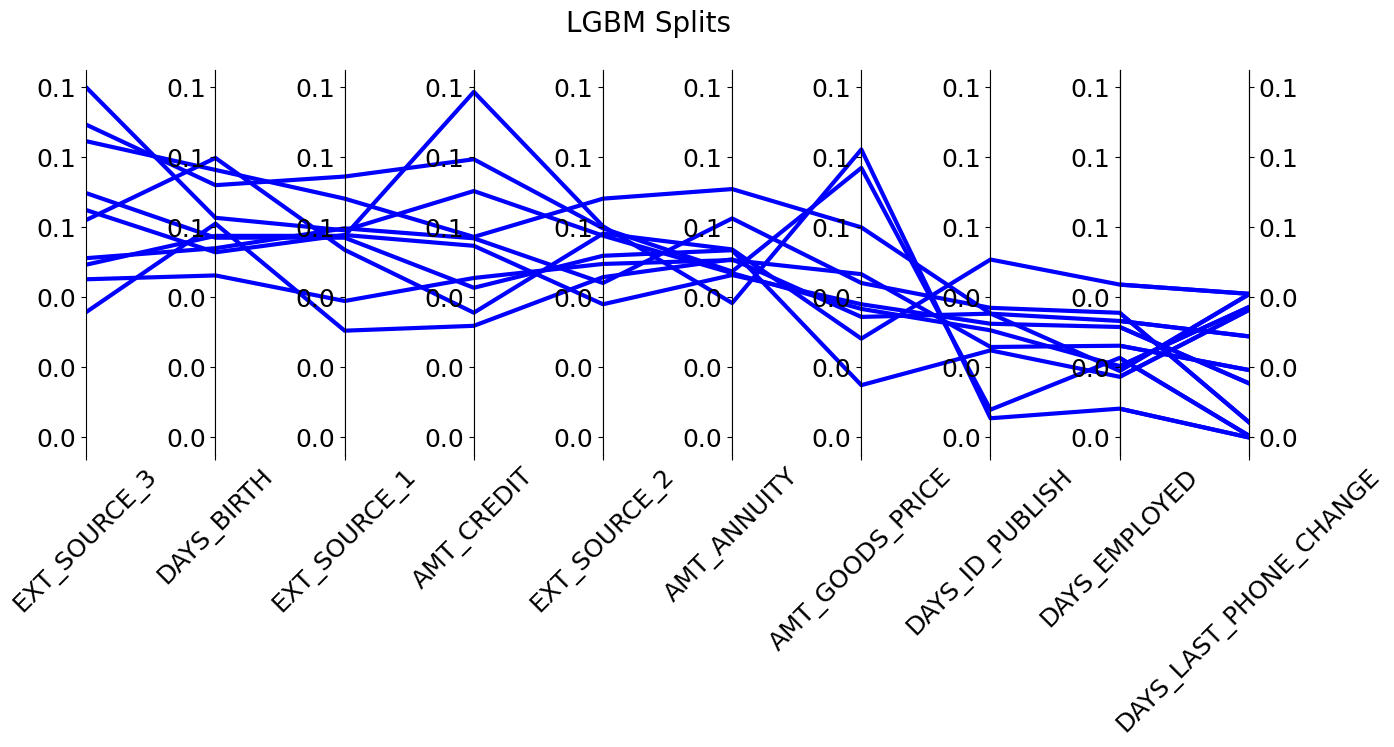

In [50]:
plot_pc_importances(lgbm_features_importance, "LGBM Splits")

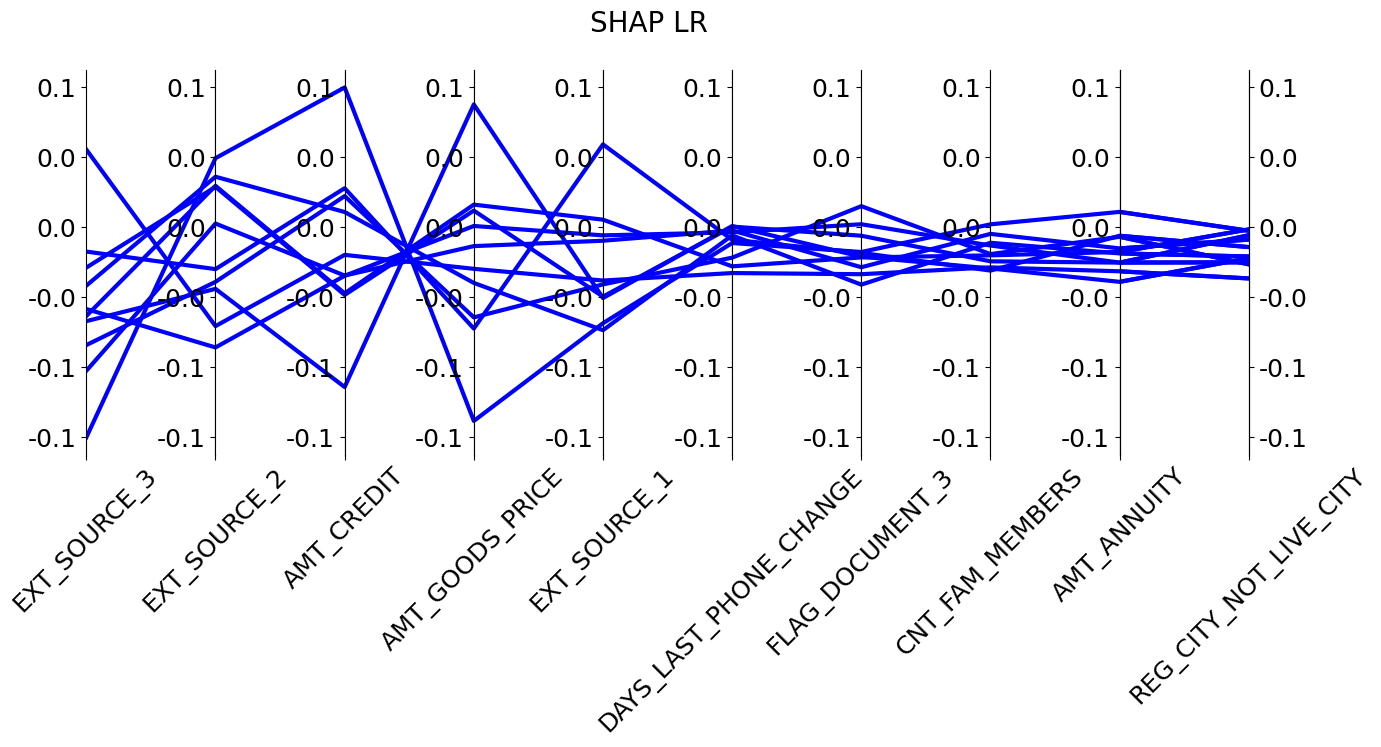

In [51]:
plot_pc_importances(shap_lr_features_importance, "SHAP LR")

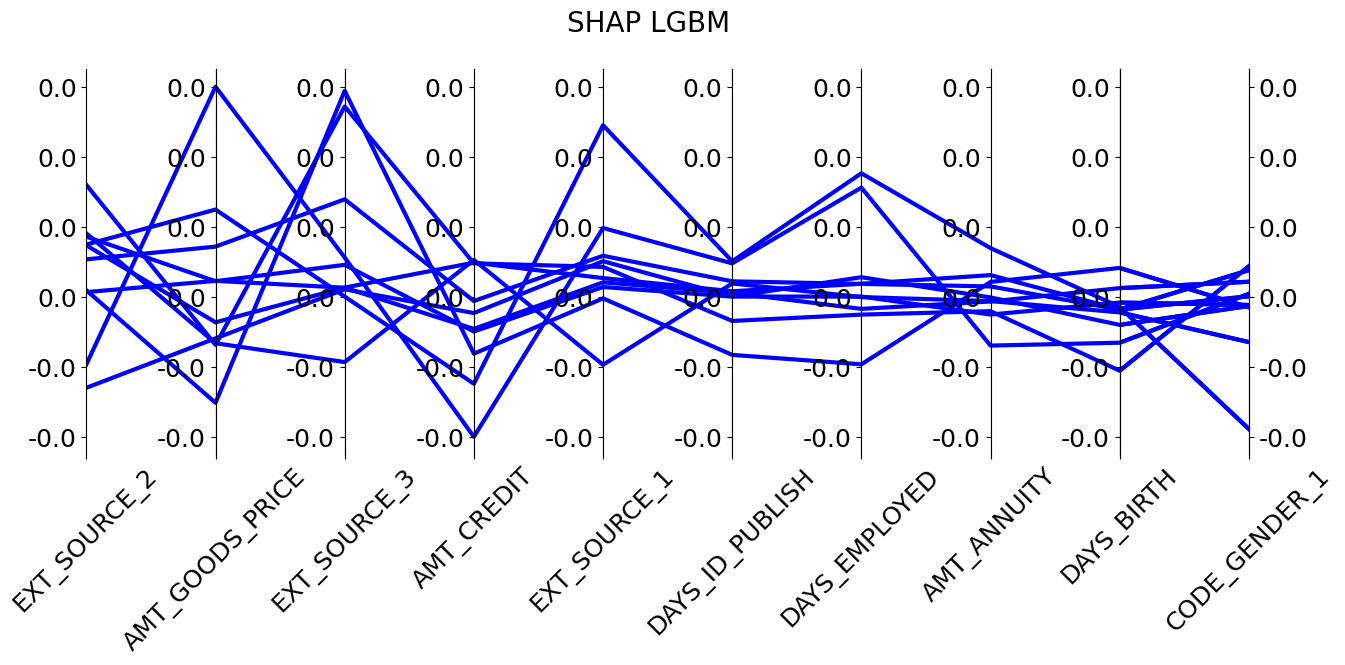

In [52]:
plot_pc_importances(shap_lgbm_features_importance, "SHAP LGBM")

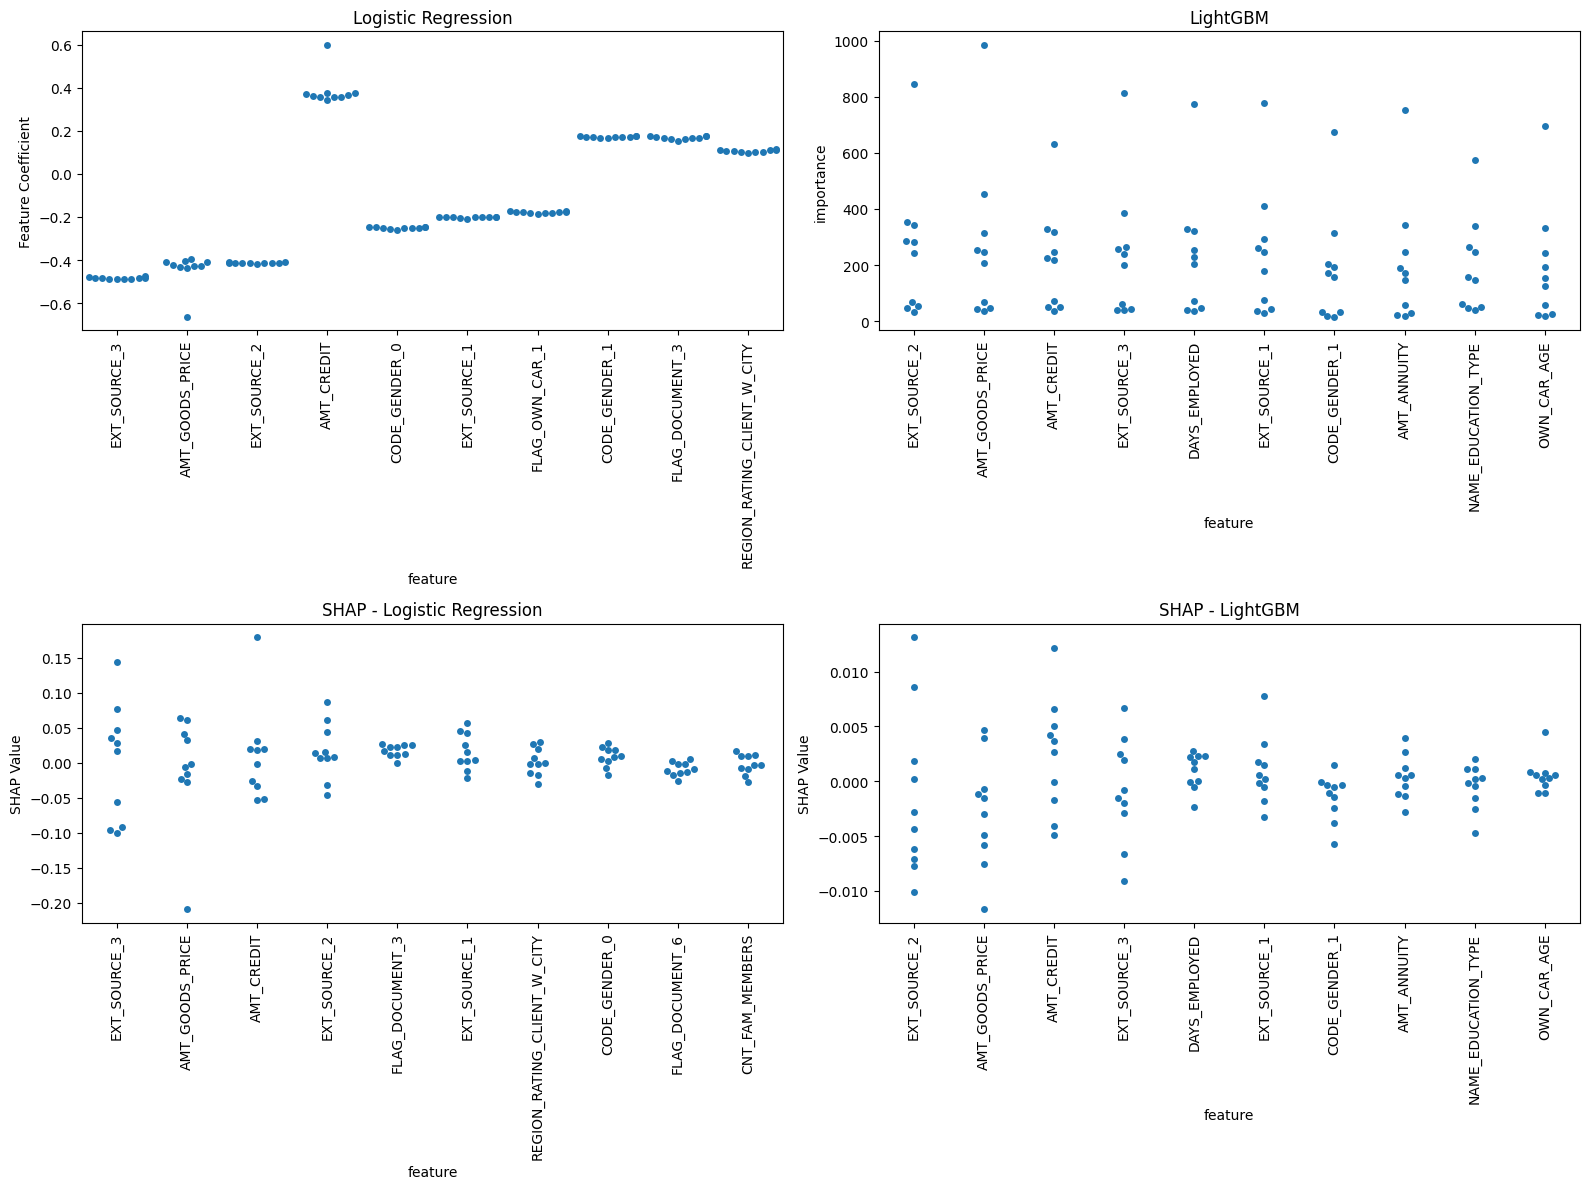

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols =2, figsize = (16, 12))
axs = axs.flatten()


def get_more_important_features(importance_values, features):
    median_importance = np.median(np.abs(importance_values), axis=0)
    sorted_idx = np.argsort(median_importance)[::-1][:10]
    features_sorted = np.array(features)[sorted_idx]
    importance_values = importance_values[:, sorted_idx]
    importances_df = []

    for i, feat in enumerate(features_sorted):
        for j in range(10):
            importances_df.append({
                "feature" : feat,
                "importance" : importance_values[j, i],
            })
    importances_df = pd.DataFrame(importances_df)
    return features_sorted, importances_df


for i, features_importance in enumerate([
    lr_features_importance, lgbm_features_importance, shap_lr_features_importance, shap_lgbm_features_importance
]):
    features_sorted, importances_df = get_more_important_features(features_importance, features)
    #for j in range(10):
    #    #axs[i].scatter(list(range(len(features_sorted))), importances[j], alpha=0.75, c = "blue")
    sns.swarmplot(data=importances_df, x="feature", y="importance", ax=axs[i])
    axs[i].set_xticks(list(range(len(features_sorted))))
    axs[i].set_xticklabels(features_sorted, rotation=90)

axs[0].set_title("Logistic Regression")
axs[0].set_ylabel("Feature Coefficient")
#axs[0].set_xticklabels(features_sorted, rotation=90)

#features_sorted, mean_sorted, std_sorted = get_more_important_features(lgbm_features_importance, features)
#axs[1].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[1].set_title("LightGBM")
axs[1].set_xticklabels(features_sorted, rotation=90)
#axs[1].set_ylabel("Feature Importance (N Splits)")

#features_sorted, mean_sorted, std_sorted = get_more_important_features(shap_lr_features_importance, features)
#axs[2].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[2].set_title("SHAP - Logistic Regression")
axs[2].set_ylabel("SHAP Value")
#axs[2].set_xticklabels(features_sorted, rotation=90)

#features_sorted, mean_sorted, std_sorted = get_more_important_features(shap_lgbm_features_importance, features)
#axs[3].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[3].set_title("SHAP - LightGBM")
axs[3].set_ylabel("SHAP Value")
#axs[3].set_xticklabels(features_sorted, rotation=90)


plt.tight_layout()
plt.savefig("test1.png")
#plt.savefig("test.pdf")
plt.show()

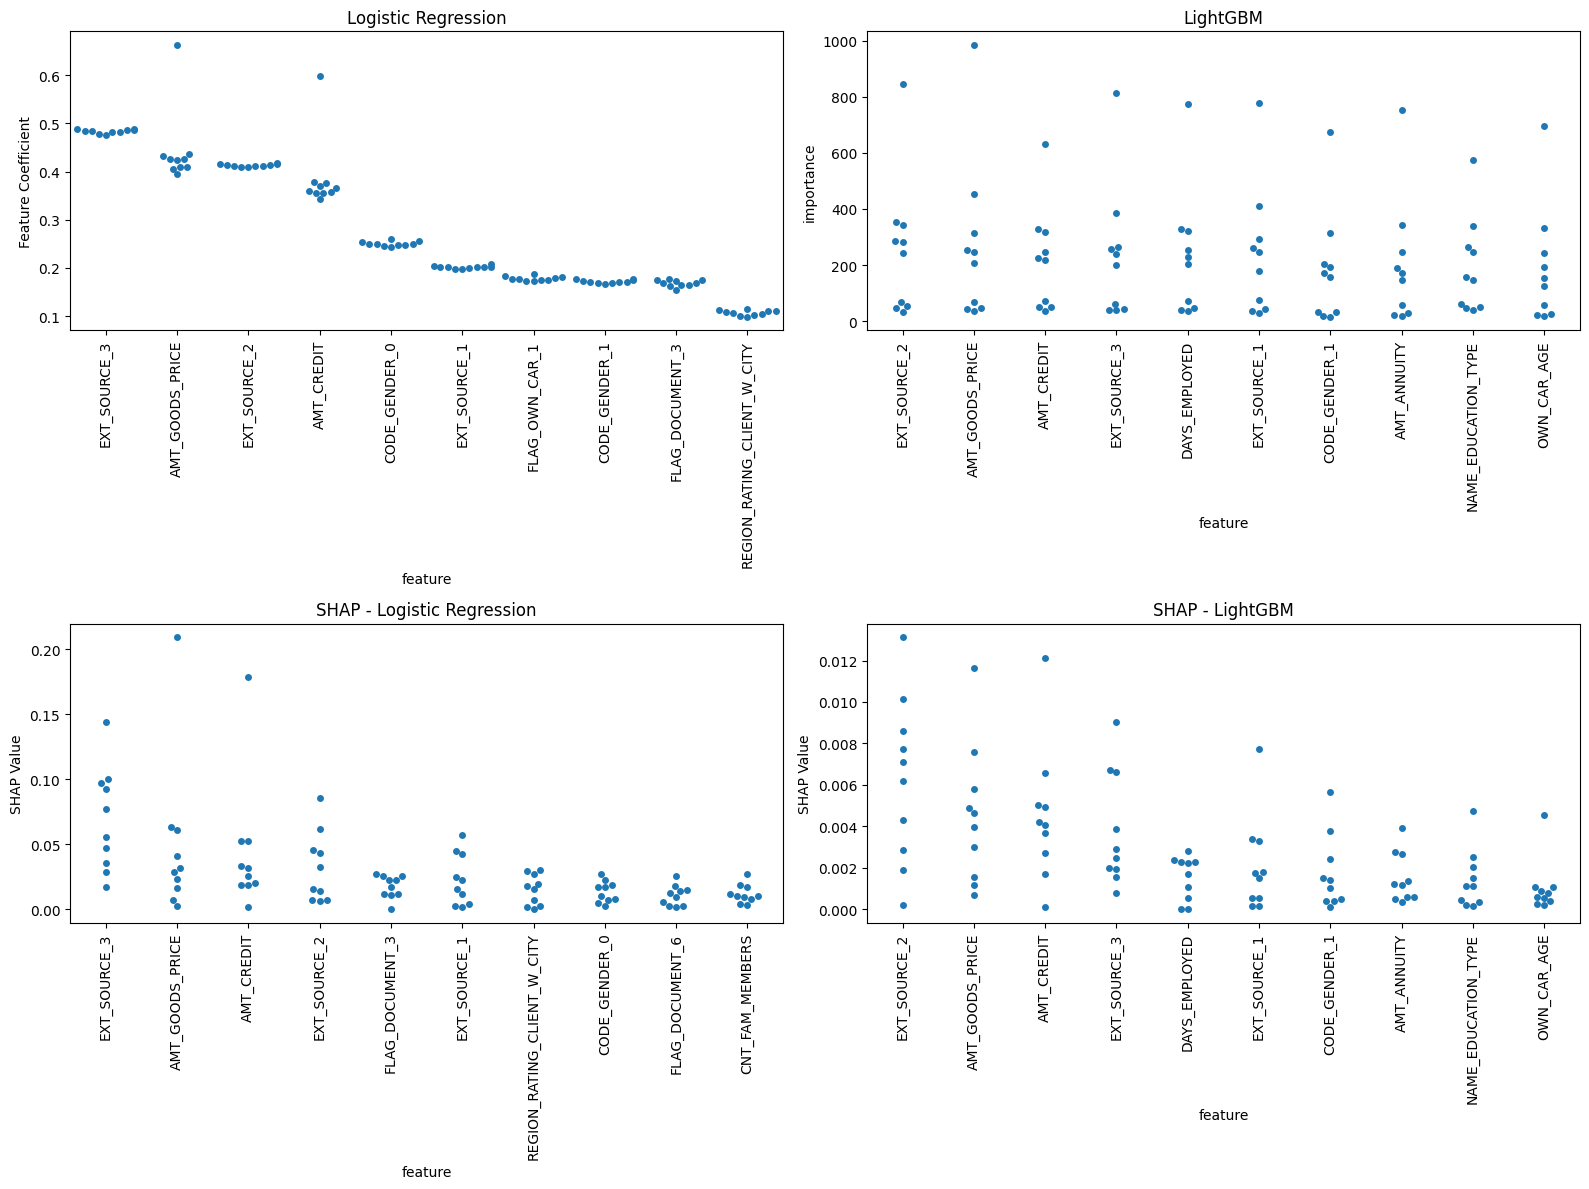

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols =2, figsize = (16, 12))
axs = axs.flatten()


def get_more_important_features(importance_values, features):
    importance_values = np.abs(importance_values)
    median_importance = np.median(np.abs(importance_values), axis=0)
    sorted_idx = np.argsort(median_importance)[::-1][:10]
    features_sorted = np.array(features)[sorted_idx]
    importance_values = importance_values[:, sorted_idx]
    importances_df = []

    for i, feat in enumerate(features_sorted):
        for j in range(10):
            importances_df.append({
                "feature" : feat,
                "importance" : importance_values[j, i],
            })
    importances_df = pd.DataFrame(importances_df)
    return features_sorted, importances_df


for i, features_importance in enumerate([
    lr_features_importance, lgbm_features_importance, shap_lr_features_importance, shap_lgbm_features_importance
]):
    features_sorted, importances_df = get_more_important_features(features_importance, features)
    #for j in range(10):
    #    #axs[i].scatter(list(range(len(features_sorted))), importances[j], alpha=0.75, c = "blue")
    sns.swarmplot(data=importances_df, x="feature", y="importance", ax=axs[i])
    axs[i].set_xticks(list(range(len(features_sorted))))
    axs[i].set_xticklabels(features_sorted, rotation=90)

axs[0].set_title("Logistic Regression")
axs[0].set_ylabel("Feature Coefficient")
#axs[0].set_xticklabels(features_sorted, rotation=90)

#features_sorted, mean_sorted, std_sorted = get_more_important_features(lgbm_features_importance, features)
#axs[1].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[1].set_title("LightGBM")
axs[1].set_xticklabels(features_sorted, rotation=90)
#axs[1].set_ylabel("Feature Importance (N Splits)")

#features_sorted, mean_sorted, std_sorted = get_more_important_features(shap_lr_features_importance, features)
#axs[2].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[2].set_title("SHAP - Logistic Regression")
axs[2].set_ylabel("SHAP Value")
#axs[2].set_xticklabels(features_sorted, rotation=90)

#features_sorted, mean_sorted, std_sorted = get_more_important_features(shap_lgbm_features_importance, features)
#axs[3].bar(features_sorted, mean_sorted, yerr=std_sorted)
axs[3].set_title("SHAP - LightGBM")
axs[3].set_ylabel("SHAP Value")
#axs[3].set_xticklabels(features_sorted, rotation=90)


plt.tight_layout()
plt.savefig("test2.png")
#plt.savefig("test.pdf")
plt.show()

In [61]:
def partial_dependence_analysis(selected_feature, grid_resolution = 10):
    path = "../results/credit_models"
    lr_pdp = []
    lgbm_pdp = []
    for fold in range(10):
        X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
            dataset_name, fold, seed
        )
        model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
        X_train_preprocess = model[:-1].transform(X_train)
        pdp = partial_dependence(model[-1], X_train_preprocess, features = [selected_feature], grid_resolution=grid_resolution, percentiles=(0.05, 0.95), method="brute")
        lr_pdp.append(pdp)

        model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
        pdp = partial_dependence(model[-1], X_train_preprocess, features = [selected_feature], grid_resolution=grid_resolution, percentiles=(0.05, 0.95), method="brute")
        lgbm_pdp.append(pdp)
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5), sharex=True, sharey=True)
    for i, pdp in enumerate([lr_pdp, lgbm_pdp]):
        for j in range(10):
            axs[i].plot(pdp[j]["values"][0], pdp[j]["average"][0], alpha=0.5, c = "blue", lw = 2.5)
        axs[i].set_title(["Logistic Regression", "LightGBM"][i])

    plt.suptitle(selected_feature)

    plt.show()

In [63]:
X_train.columns.tolist()

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTR

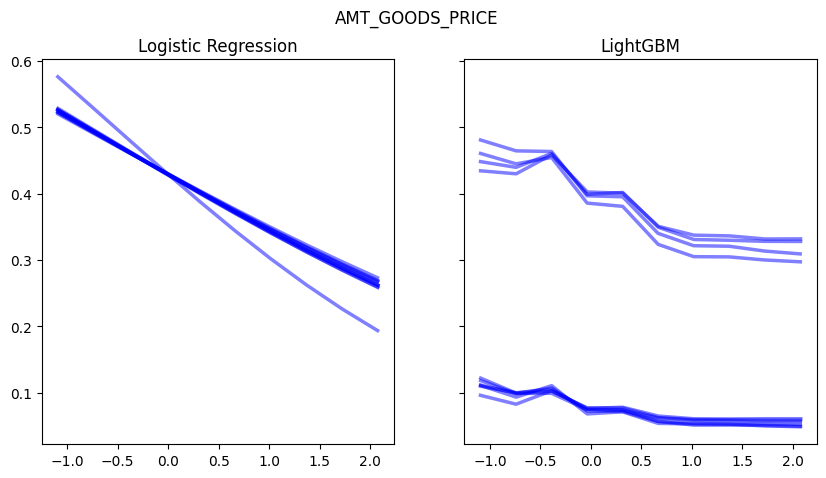

In [64]:
partial_dependence_analysis("AMT_GOODS_PRICE")

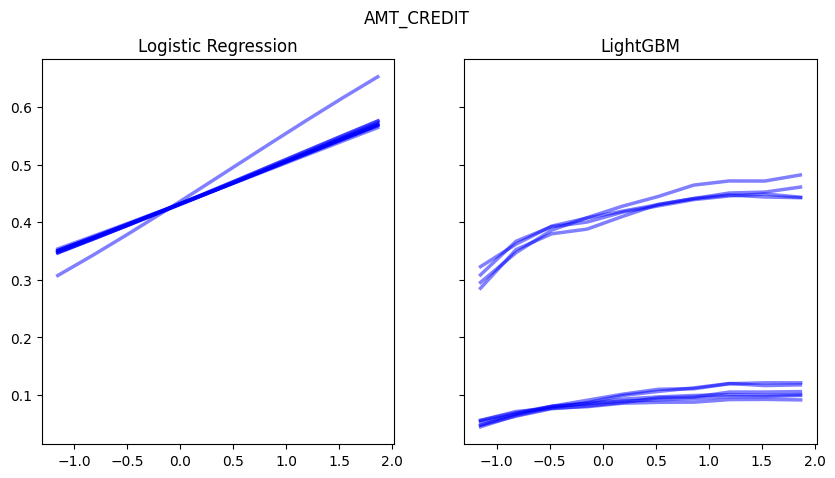

In [65]:
partial_dependence_analysis("AMT_CREDIT")

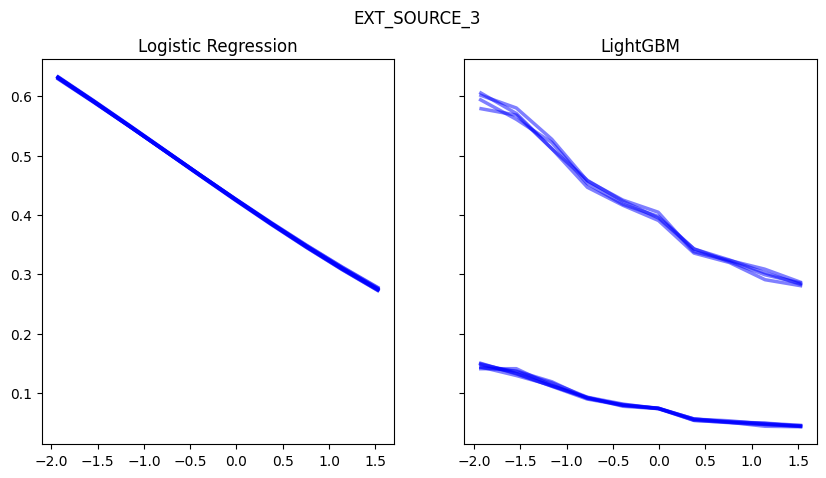

In [66]:
partial_dependence_analysis("EXT_SOURCE_3")

In [ ]:
partial_dependence_analysis("AMT_INCOME_TOTAL")

In [99]:
def ice_analysis(selected_feature, grid_resolution = 10, fold = 0):
    path = "../results/credit_models"
    
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    X_train = X_train.sample(100)
    #model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    model = joblib.load(f'../results/fair_models/{dataset_name}/{fold}/FairGBMClassifier.pkl')
    X_train_preprocess = model[:-1].transform(X_train)
    fairgbm_pdfp = partial_dependence(model[-1], X_train_preprocess, features = [selected_feature], grid_resolution=grid_resolution, percentiles=(0.05, 0.95), method="brute", kind = "individual")

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    X_train_preprocess = model[:-1].transform(X_train)
    lgbm_pdp = partial_dependence(model[-1], X_train_preprocess, features = [selected_feature], grid_resolution=grid_resolution, percentiles=(0.05, 0.95), method="brute", kind = "individual")


    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5), sharex=True, sharey=True)
    color_code = {
        "M" : "blue",
        "F" : "red"
    }
    for i, pdp in enumerate([lgbm_pdp, fairgbm_pdfp]):
        for j in range(X_train.shape[0]):
            axs[i].plot(pdp["values"][0], pdp["individual"][0, j, :], alpha=0.5, c = color_code[X_train.CODE_GENDER.values[j]], lw = 1)
        axs[i].set_title(["LightGBM", "FairGBM"][i])

    plt.suptitle(selected_feature)

    plt.show()

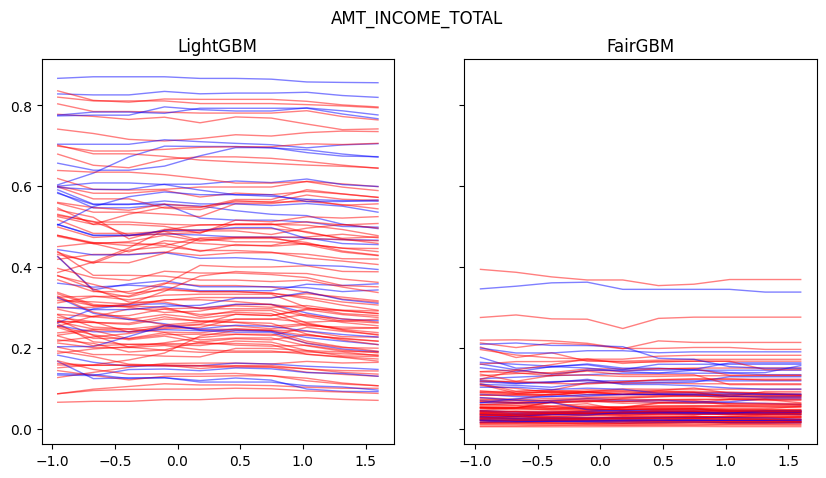

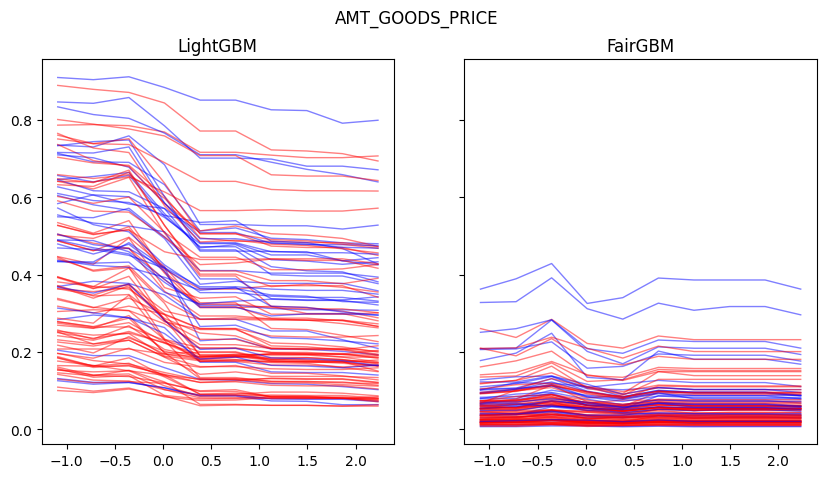

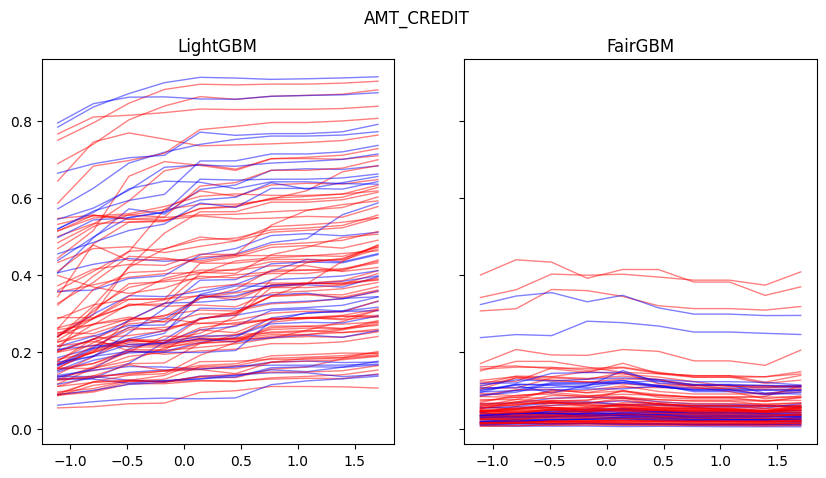

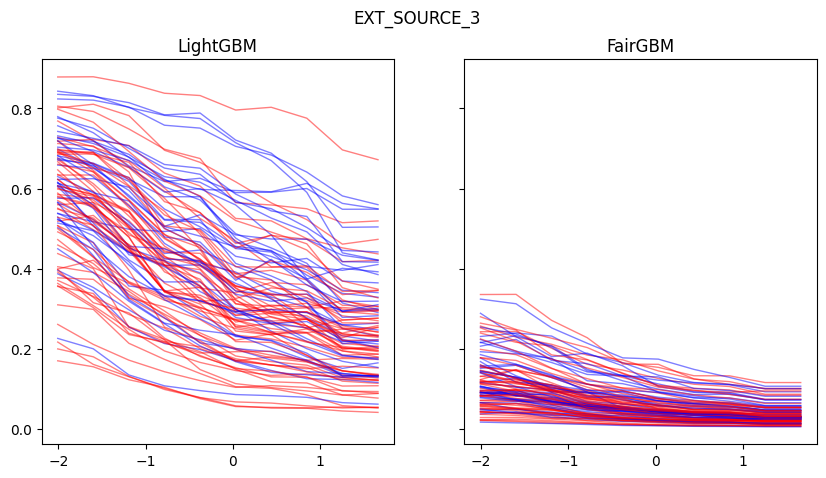

In [100]:
for col in ["AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "AMT_CREDIT", "EXT_SOURCE_3"]:
    ice_analysis(col)